In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))
display(HTML("<style>div.output_scroll { height: 200em; }</style>"))

In [2]:
import sys
sys.path.insert(0, '/users/jtan/hera_pspec')
sys.path.insert(0, '/users/jtan/hera_pspec/hera_pspec') 

In [3]:
%matplotlib inline
#%load_ext line_profiler
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import hera_cal as hc
import hera_pspec as hp
from hera_pspec.data import DATA_PATH
from pyuvdata import UVData, UVCal, UVFlag, utils as uvutils
from scipy import stats, signal, interpolate
import copy
import matplotlib.gridspec as gridspec
from astropy import constants
import uvtools as uvt
import cycler
import itertools
import os
from collections import OrderedDict as odict

/lustre/aoc/projects/hera/jtan/anaconda3/envs/hera_pspec_py3/lib/python3.6/site-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/lustre/aoc/projects/hera/jtan/anaconda3/envs/hera_pspec_py3/lib/python3.6/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/lustre/aoc/projects/hera/jtan/anaconda3/envs/hera_pspec_py3/lib/python3.6/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/lustre/aoc/projects/hera/jtan/anaconda3/envs/hera_pspec_py3/lib/python3.6/site-packages/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
no

In [4]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [5]:
import matplotlib.ticker as ticker

In [6]:
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [7]:
import matplotlib.font_manager

## Null tests on pure-noise simulations

In [39]:
from hera_pspec.data import DATA_PATH
cosmo = hp.conversions.Cosmo_Conversions()
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

#### simulate data

In [40]:
bls1, bls2, blpairs= [(23, 37)], [(36, 51)], [((23, 37), (36, 51))]

In [41]:
hd = hc.io.HERAData('/lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/clean.uvh5')
data, flags, nsamples = hd.read(freq_chans=np.arange(550, 650))

In [42]:
spws = (0, 99)

In [43]:
Jy_to_mK = uvb.Jy_to_mK(hd.freq_array[0], pol='xx')

In [46]:
known_cov = {}
model = 'noise'
Ntimes = 21
Nfreqs = 100

for blpair in blpairs:
    dset1, bl1 = 0, (blpair[0][0],blpair[0][1],'xx')
    dset2, bl2 = 1, (blpair[1][0],blpair[1][1],'xx')
    
    bl= (blpair[0][0], blpair[0][1], 'ee')
    dt = nsamples[bl] * hd.integration_time[0]
    df = hd.channel_width
    nvar1 = hc.redcal.predict_noise_variance_from_autos(bl, data, dt=dt, df=df)
    nvar1[np.isnan(nvar1)] = 0.0 
    nvar1 *= Jy_to_mK**2
    
    bl= (blpair[1][0], blpair[1][1], 'ee')
    dt = nsamples[bl] * hd.integration_time[0]
    df = hd.channel_width
    nvar2 = hc.redcal.predict_noise_variance_from_autos(bl, data, dt=dt, df=df)
    nvar2[np.isnan(nvar2)] = 0.0 
    nvar2 *= Jy_to_mK**2
    
    for time_index in range(Ntimes):
        C_n_11 = np.diag(nvar1[600+time_index,:Nfreqs])
        C_n_22 = np.diag(nvar2[600+time_index,:Nfreqs])
           
        Ckey = ((dset1, dset1), (bl1,bl1), ) + (model, time_index, False, True,)
        known_cov[Ckey] = C_n_11
        Ckey = ((dset1, dset1), (bl1,bl1), ) + (model, time_index, False, False,)
        known_cov[Ckey] = np.zeros_like(C_n_11)
        Ckey = ((dset1, dset1), (bl1,bl1), ) + (model, time_index, True, True,)
        known_cov[Ckey] = np.zeros_like(C_n_11)

        Ckey = ((dset2, dset2), (bl2,bl2), ) + (model, time_index, False, True,)
        known_cov[Ckey] = C_n_22
        Ckey = ((dset2, dset2), (bl2,bl2), ) + (model, time_index, False, False,)
        known_cov[Ckey] = np.zeros_like(C_n_11)
        Ckey = ((dset2, dset2), (bl2,bl2), ) + (model, time_index, True, True,)
        known_cov[Ckey] = np.zeros_like(C_n_11)

        Ckey = ((dset1, dset2), (bl1,bl2), ) + (model, time_index, False, True,)
        known_cov[Ckey] = np.zeros_like(C_n_11)
        Ckey = ((dset2, dset1), (bl2,bl1), ) + (model, time_index, False, True,)
        known_cov[Ckey] = np.zeros_like(C_n_11)
        Ckey = ((dset2, dset1), (bl2,bl1), ) + (model, time_index, False, False,)
        known_cov[Ckey] = np.zeros_like(C_n_11)
        Ckey = ((dset2, dset1), (bl2,bl1), ) + (model, time_index, True, True,)
        known_cov[Ckey] = np.zeros_like(C_n_11)

#### Load data and generate power spectrum

There are already noise realizations from the input covariance specified above. 

In [47]:
#uvp_td_11s, uvp_td_12s, uvps = [], [], []
uvps = []
for i, df in enumerate(sorted(glob.glob("/lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_*.uvh5"))):
    print(i, df)
    uvn_ = UVData()
    uvn_.read_uvh5(df)
    uvn = uvn_.select(time_range=[2458116.3192, 2458116.3244], inplace=False)
    uvn.data_array *= Jy_to_mK[None, None, :, None]
    ds = hp.PSpecData(dsets=[uvn, uvn], wgts=[None, None], beam=uvb)
    # change units of UVData objects
    ds.dsets[0].vis_units = 'mK'
    ds.dsets[1].vis_units = 'mK'
    #uvn_1 = uvn.select(times=np.unique(uvn.time_array)[0:-1:1],inplace=False)
    #uvn_2 = uvn.select(times=np.unique(uvn.time_array)[1::1],inplace=False)
    #uvn_td = copy.deepcopy(uvn_1)
    #uvn_td.data_array = (uvn_1.data_array - uvn_2.data_array)/np.sqrt(2)
    #ds_td = hp.PSpecData(dsets=[uvn_td, uvn_td], wgts=[None, None], beam=uvb)
    
    #uvp_td_11, uvp_td_q_11 = ds_td.pspec( bls1, bls1, (0, 1), [(-5, -5)], spw_ranges=spws, input_data_weight='identity', 
    #                                    norm='I', taper='blackman-harris', store_cov = False, verbose=False)
    #uvp_td_12, uvp_td_q_12 = ds_td.pspec( bls1, bls2, (0, 1), [(-5, -5)], spw_ranges=spws, input_data_weight='identity', 
    #                                                                           norm='I', taper='blackman-harris', store_cov = False, verbose=False)
    uvp = ds.pspec( bls1, bls2, (0, 1), [(-5, -5)], spw_ranges=spws, input_data_weight='identity', 
                      norm='I', taper='blackman-harris', store_cov = True, cov_model='noise', known_cov=known_cov, verbose=False)
    uvp.write_hdf5("noise_{}_uvpspec3".format(i), overwrite=True)
    #uvp_td_11s.append(uvp_td_11)
    #uvp_td_12s.append(uvp_td_12)
    uvps.append(uvp)

0 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_00.uvh5


000001ee in extra_keywords is a list, array or dict, which will raise an error when writing uvfits or miriad file types
000001nn in extra_keywords is a list, array or dict, which will raise an error when writing uvfits or miriad file types
000002ee in extra_keywords is a list, array or dict, which will raise an error when writing uvfits or miriad file types
000002nn in extra_keywords is a list, array or dict, which will raise an error when writing uvfits or miriad file types
000011ee in extra_keywords is a list, array or dict, which will raise an error when writing uvfits or miriad file types
000011nn in extra_keywords is a list, array or dict, which will raise an error when writing uvfits or miriad file types
000012ee in extra_keywords is a list, array or dict, which will raise an error when writing uvfits or miriad file types
000012nn in extra_keywords is a list, array or dict, which will raise an error when writing uvfits or miriad file types
000013ee in extra_keywords is a list, ar

Casting complex values to real discards the imaginary part


1 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_01.uvh5
2 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_02.uvh5
3 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_03.uvh5
4 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_04.uvh5
5 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_05.uvh5
6 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_06.uvh5
7 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_07.uvh5
8 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_08.uvh5
9 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_09.uvh5
10 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noi

82 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_82.uvh5
83 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_83.uvh5
84 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_84.uvh5
85 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_85.uvh5
86 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_86.uvh5
87 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_87.uvh5
88 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_88.uvh5
89 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_89.uvh5
90 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests/data/noise_90.uvh5
91 /lustre/aoc/projects/hera/nkern/h1c_idr2_analysis/H1C_IDR2/notebooks/null_tests

In [9]:
uvps = []
for i, df in enumerate(sorted(glob.glob("/lustre/aoc/projects/hera/jtan/h1c_idr2_notebooks/noise_*_uvpspec3"))):
    uvp = hp.UVPSpec()
    uvp.read_hdf5(df)
    uvps.append(uvp)

#### pdf of power spectrum from one time sample, averaged over 5 samples, averaged over 10 samples, averaged over 15 samples

beyond 3sigma 0.012731130645650146 Gauss 0.002367061055388506 Laplacian 0.013435412744030454
beyond 3sigma 0.005656565656565663 Gauss 0.0022854398933772756 Laplacian 0.005781836394744616
beyond 3sigma 0.002525252525252643 Gauss 0.0022434746069399706 Laplacian 0.003522942033211541


Text(0.5, 0.99, 'Pure noise simulations')

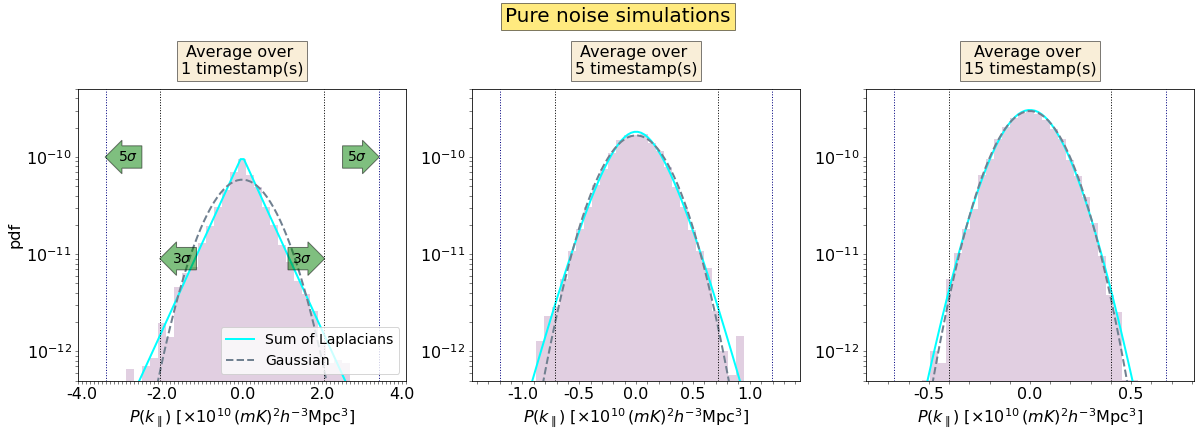

In [10]:
num_time_samples_list = [1,5,15]
fig, axes = plt.subplots(figsize=(20,6), ncols=3, nrows=1)
for ax_idx, num_time_samples in enumerate(num_time_samples_list):
    col_idx = ax_idx%3
    times = np.arange(num_time_samples)
   
    # Get all keys
    _key = uvp.get_all_keys()[0]

    blpt_weights = np.array([1. for item in times]).reshape(-1)
    Nspwdlys = len(uvps[0].get_dlys(0))
    ps_real_avg = []
    for dly in range(Nspwdlys):
        for uvp_plot in uvps:
            ps = np.array([uvp_plot.get_data(_key)[time, dly] for time in times]).reshape(-1)
            ps_real_avg.append(np.sum(ps.real*blpt_weights)/np.sum(blpt_weights).clip(1e-10, np.inf))

    # The ratio of error bars to the original one
    psunits = uvps[0].units
    if "h^-1" in psunits: psunits = psunits.replace("h^-1", "h^{-1}")
    if "h^-3" in psunits: psunits = psunits.replace("h^-3", "h^{-3}")
    if "Mpc" in psunits and "\\rm" not in psunits: 
        psunits = psunits.replace("Mpc", r"{\rm Mpc}")
    if "pi" in psunits and "\\pi" not in psunits: 
        psunits = psunits.replace("pi", r"\pi")
    nbins = 41
    ax = axes[col_idx]
    d = ps_real_avg - np.mean(ps_real_avg)
    vlim = 6*np.std(d)
    n_in_bins, bins_edge, _ = ax.hist(d, bins=nbins, log=True, density=True, range=(-vlim, vlim), color='thistle', alpha=0.75)
    ax.set_xlim(-vlim, vlim)
    ax.set_ylim(5*1e-13,5*1e-10)
    
    # Calculate the predicted pdf
    Lap_sigma_list = np.zeros(num_time_samples)
    for time in times:
        Lap_sigma_list[time] = np.sqrt(np.mean(np.abs(np.diag(uvps[0].get_cov(_key,component='real')[time])))) 
    px = np.linspace(-vlim, vlim, 100)
    Lap_curve = np.zeros_like(px)
    normalized_factor = 0
    for time in times:
        scale_factor = 1
        for time_ in times:
            if time_ != time:
                scale_factor *= Lap_sigma_list[time]**2/(Lap_sigma_list[time]**2-Lap_sigma_list[time_]**2)
        normalized_factor += scale_factor   
        Lap_curve += np.exp(-np.sqrt(2)*np.abs(px)/Lap_sigma_list[time]*num_time_samples)/np.sqrt(2)/Lap_sigma_list[time]*num_time_samples*scale_factor
    
    # Calculate the equivalent Gaussian pdf
    Gauss_sigma = np.sqrt(np.sum(Lap_sigma_list**2))/num_time_samples
    Gauss_curve = np.exp(-px**2/2/Gauss_sigma**2)/np.sqrt(2*np.pi*Gauss_sigma**2)
    if np.isclose(normalized_factor,1,rtol=5e-1):
        ax.plot(px, Lap_curve, ls='-', lw=2, label="Sum of Laplacians", c='cyan')
    ax.plot(px, Gauss_curve, ls='--', lw=2, label='Gaussian', c='slategrey')
    bins_center = (bins_edge[1:] + bins_edge[0:-1])/2
    outlier_3sigma = (np.sum(n_in_bins)-np.sum(n_in_bins[(-3*Gauss_sigma<=bins_center)*(bins_center<=3*Gauss_sigma)]))/np.sum(n_in_bins)
    print("beyond 3sigma {}".format(outlier_3sigma), \
          "Gauss {}".format((np.sum(Gauss_curve)-np.sum(Gauss_curve[(-3*Gauss_sigma<=px)*(px<=3*Gauss_sigma)]))/np.sum(Gauss_curve)), \
          "Laplacian {}".format((np.sum(Lap_curve)-np.sum(Lap_curve[(-3*Gauss_sigma<=px)*(px<=3*Gauss_sigma)]))/np.sum(Lap_curve)))

    # confidence interval
    ax.axvline(x=3*Gauss_sigma, c='k', lw=1, ls=':')
    ax.axvline(x=-3*Gauss_sigma, c='k', lw=1, ls=':')
    ax.axvline(x=5*Gauss_sigma, c='navy', lw=1, ls=':')
    ax.axvline(x=-5*Gauss_sigma, c='navy', lw=1, ls=':')
    if ax_idx == 0:
        ax.text(2.2*Gauss_sigma, 9*1e-12, r'$3 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="rarrow", fc="green", alpha=0.5))
        ax.text(4.2*Gauss_sigma, 1e-10, r'$5 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="rarrow", fc="green", alpha=0.5))
        ax.text(-2.2*Gauss_sigma, 9*1e-12, r'$3 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="larrow", fc="green", alpha=0.5))
        ax.text(-4.2*Gauss_sigma, 1e-10, r'$5 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="larrow", fc="green", alpha=0.5))
    
    ax.tick_params(which='both', labelsize=16, length=3, width=0.5)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1e9))
    xticks = ax.get_xticks()
    ax.set_xticklabels(xticks/1e10)
    ax.set_xlabel("$P(k_\parallel)$ $[\\times 10^{10}\,%s]$" % psunits, fontsize=16)
    if col_idx == 0: 
        ax.set_ylabel("pdf", fontsize=16)
    if ax_idx == 0:
        ax.legend(loc='lower right', fontsize=14)
    ax.set_title("Average over \n{} timestamp(s)".format(num_time_samples),bbox=dict(fc='wheat', alpha=0.5), fontsize=16, pad=15)
fig.subplots_adjust(top=0.8)
fig.suptitle("Pure noise simulations", fontsize=20, bbox=dict(fc='gold', alpha=0.5), x=0.5, y=0.99)    

In [11]:
len(uvps)*len(uvps[0].get_dlys(0))

9900

# Null tests on IDR2.2 data

In [12]:
# load power spectra
psc = hp.PSpecContainer('pspec_nulltest.h5', keep_open=False)
[uvp_cross] = psc.get_pspec('pI_shortbl')

In [13]:
delay_resolution = 1 / (uvp_cross.freq_array[-1]-uvp_cross.freq_array[0])*1e9

In [15]:
# load power spectra
psc = hp.PSpecContainer('pspec_nulltest.h5', keep_open=False)
[uvp_cross] = psc.get_pspec('pI_medbl')

#### on short baseline group

In [14]:
print(delay_resolution)

57.20670391061453


A larger window (2000), with normalization, consider normalization

beyond 3sigma 0.014798694232862042 Gauss 0.002428115998335297 Laplacian 0.013579845438731222
beyond 3sigma 0.006345867933423045 Gauss 0.0024281159983348833 Laplacian 0.005718742614672368
beyond 3sigma 0.003916307067484065 Gauss 0.002428115998334845 Laplacian -0.00019801080173907935
27577


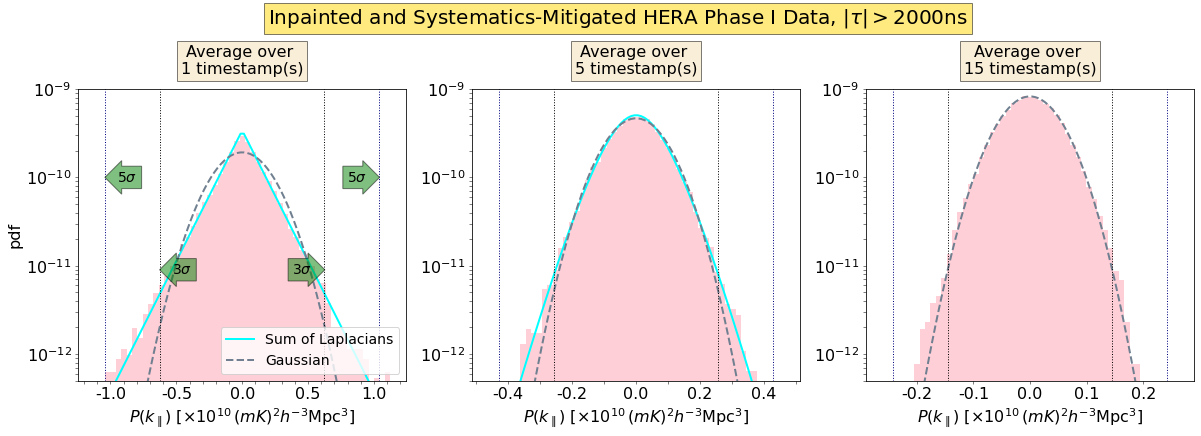

In [15]:
# used in paper
# A larger window (2000), with normalization
uvp_plot = uvp_cross
num_time_samples_list = [1,5,15]
ylim = (5*1e-13,1e-9)
dlys = uvp_plot.get_dlys(0) * 1e9
delay_args = np.append(np.argwhere(dlys< -2000), np.argwhere(dlys> 2000))
suptitle = "Inpainted and Systematics-Mitigated HERA Phase I Data, "+r"$|\tau|>2000 {\rm ns}$"

fig, axes = plt.subplots(figsize=(20,6), ncols=3, nrows=1)
for ax_idx, num_time_samples in enumerate(num_time_samples_list):
    col_idx = ax_idx%3
    times = np.arange(num_time_samples)
   
    # Get all keys
    keys = uvp_plot.get_all_keys()
    blpt_weights = np.array([[1. for item in times] for key in keys])
    ps_real_time_avg = []
    for dly in delay_args:
        ps = np.array([[uvp_plot.get_data(key)[time, dly]*uvp_plot.get_stats("autos_diag", keys[0])[time,0].real\
                        /uvp_plot.get_stats("autos_diag", key)[time, dly].real for time in times] for key in keys])
        ps_real_time_avg.extend((np.sum(ps.real*blpt_weights, axis=1)/np.sum(blpt_weights, axis=1).clip(1e-10, np.inf)).flatten())
    ps_real_time_avg = np.array(ps_real_time_avg) - np.mean(ps_real_time_avg)
    # The ratio of error bars to the original one
    psunits = uvp_plot.units
    if "h^-1" in psunits: psunits = psunits.replace("h^-1", "h^{-1}")
    if "h^-3" in psunits: psunits = psunits.replace("h^-3", "h^{-3}")
    if "Mpc" in psunits and "\\rm" not in psunits: 
        psunits = psunits.replace("Mpc", r"{\rm Mpc}")
    if "pi" in psunits and "\\pi" not in psunits: 
        psunits = psunits.replace("pi", r"\pi")
    
    ax = axes[col_idx]
    Lap_sigma_list = np.zeros(num_time_samples)
    for time in times:
        Lap_sigma_list[time] = uvp_plot.get_stats("autos_diag", keys[0])[time, 0].real 
    Gauss_sigma = np.sqrt(np.sum(Lap_sigma_list**2))/num_time_samples
    vlim = 6*Gauss_sigma
    n_in_bins, bins_edge, _ = ax.hist(ps_real_time_avg, log=True, density=True, bins=61, range=(-vlim, vlim), alpha=0.75,
                           color='pink')
    ax.set_xlim(-vlim, vlim)
    ax.set_ylim(*ylim)
    
    px = np.linspace(-vlim, vlim, 100)
    Lap_curve = np.zeros_like(px)
    normalized_factor = 0
    for time in times:
        scale_factor = 1
        for time_ in times:
            if time_ != time:
                scale_factor *= Lap_sigma_list[time]**2/(Lap_sigma_list[time]**2-Lap_sigma_list[time_]**2)
        normalized_factor += scale_factor   
        Lap_curve += np.exp(-np.sqrt(2)*np.abs(px)/Lap_sigma_list[time]*num_time_samples)/np.sqrt(2)/Lap_sigma_list[time]*num_time_samples*scale_factor
    
    # Calculate the equivalent Gaussian pdf
    Gauss_curve = np.exp(-px**2/2/Gauss_sigma**2)/np.sqrt(2*np.pi*Gauss_sigma**2)
    
    if np.isclose(normalized_factor,1,rtol=5e-1):
        ax.plot(px, Lap_curve, ls='-', lw=2, label="Sum of Laplacians", c='cyan')
    ax.plot(px, Gauss_curve, ls='--', lw=2, label='Gaussian', c='slategrey')
    bins_center = (bins_edge[1:] + bins_edge[0:-1])/2
    outlier_3sigma = (np.sum(n_in_bins)-np.sum(n_in_bins[(-3*Gauss_sigma<=bins_center)*(bins_center<=3*Gauss_sigma)]))/np.sum(n_in_bins)
    print("beyond 3sigma {}".format(outlier_3sigma), \
          "Gauss {}".format((np.sum(Gauss_curve)-np.sum(Gauss_curve[(-3*Gauss_sigma<=px)*(px<=3*Gauss_sigma)]))/np.sum(Gauss_curve)), \
          "Laplacian {}".format((np.sum(Lap_curve)-np.sum(Lap_curve[(-3*Gauss_sigma<=px)*(px<=3*Gauss_sigma)]))/np.sum(Lap_curve)))

    # confidence interval
    ax.axvline(x=3*Gauss_sigma, c='k', lw=1, ls=':')
    ax.axvline(x=-3*Gauss_sigma, c='k', lw=1, ls=':')
    ax.axvline(x=5*Gauss_sigma, c='navy', lw=1, ls=':')
    ax.axvline(x=-5*Gauss_sigma, c='navy', lw=1, ls=':')
    if ax_idx == 0:
        ax.text(2.2*Gauss_sigma, 9*1e-12, r'$3 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="rarrow", fc="green", alpha=0.5))
        ax.text(4.2*Gauss_sigma, 1e-10, r'$5 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="rarrow", fc="green", alpha=0.5))
        ax.text(-2.2*Gauss_sigma, 9*1e-12, r'$3 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="larrow", fc="green", alpha=0.5))
        ax.text(-4.2*Gauss_sigma, 1e-10, r'$5 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="larrow", fc="green", alpha=0.5))
    
    ax.tick_params(which='both', labelsize=16, length=3, width=0.5)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1e9))
    xticks = ax.get_xticks()
    ax.set_xticklabels(xticks/1e10)
    ax.set_xlabel("$P(k_\parallel)$ $[\\times 10^{10}\,%s]$" % psunits, fontsize=16)
    if col_idx == 0: 
        ax.set_ylabel("pdf", fontsize=16)
    if ax_idx == 0:
        ax.legend(loc='lower right', fontsize=14)
    ax.set_title("Average over \n{} timestamp(s)".format(num_time_samples),bbox=dict(fc='wheat', alpha=0.5), fontsize=16, pad=15)
fig.subplots_adjust(top=0.8)
fig.suptitle(suptitle, fontsize=20, bbox=dict(fc='gold', alpha=0.5), x=0.5, y=0.99)
print(len(uvp_plot.get_all_keys())*len(delay_args))

beyond 3sigma 0.021870535223651177 Gauss 0.002428115998335297 Laplacian 0.013579845438731222
beyond 3sigma 0.01317523056653515 Gauss 0.0024281159983348833 Laplacian 0.005718742614672368
beyond 3sigma 0.008014931927975352 Gauss 0.002428115998334845 Laplacian -0.00019801080173907935
9108


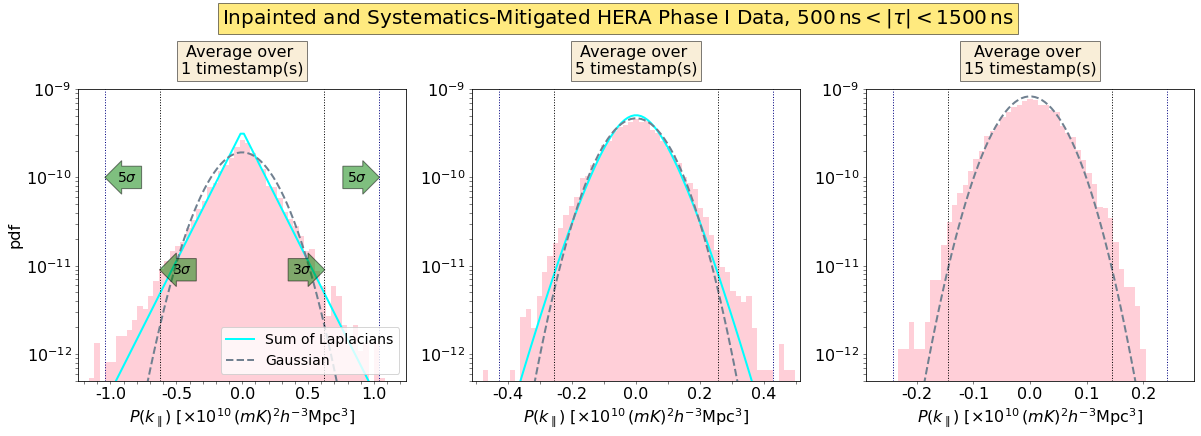

In [16]:
# used in paper
# A larger window (500-1500), with normalization
uvp_plot = uvp_cross
num_time_samples_list = [1,5,15]
ylim = (5*1e-13,1e-9)
dlys = uvp_plot.get_dlys(0) * 1e9
delay_args = np.append(np.argwhere((dlys< -500)*(dlys>-1500)), np.argwhere((dlys< 1500)*(dlys>500)))
suptitle = "Inpainted and Systematics-Mitigated HERA Phase I Data, "+r"$500\,{\rm ns}<|\tau|<1500\,{\rm ns}$"

fig, axes = plt.subplots(figsize=(20,6), ncols=3, nrows=1)
for ax_idx, num_time_samples in enumerate(num_time_samples_list):
    col_idx = ax_idx%3
    times = np.arange(num_time_samples)
   
    # Get all keys
    keys = uvp_plot.get_all_keys()
    blpt_weights = np.array([[1. for item in times] for key in keys])
    ps_real_time_avg = []
    for dly in delay_args:
        ps = np.array([[uvp_plot.get_data(key)[time, dly]*uvp_plot.get_stats("autos_diag", keys[0])[time,0].real\
                        /uvp_plot.get_stats("autos_diag", key)[time, dly].real for time in times] for key in keys])
        ps_real_time_avg.extend((np.sum(ps.real*blpt_weights, axis=1)/np.sum(blpt_weights, axis=1).clip(1e-10, np.inf)).flatten())
    ps_real_time_avg = np.array(ps_real_time_avg) - np.mean(ps_real_time_avg)
    # The ratio of error bars to the original one
    psunits = uvp_plot.units
    if "h^-1" in psunits: psunits = psunits.replace("h^-1", "h^{-1}")
    if "h^-3" in psunits: psunits = psunits.replace("h^-3", "h^{-3}")
    if "Mpc" in psunits and "\\rm" not in psunits: 
        psunits = psunits.replace("Mpc", r"{\rm Mpc}")
    if "pi" in psunits and "\\pi" not in psunits: 
        psunits = psunits.replace("pi", r"\pi")
    
    ax = axes[col_idx]
    Lap_sigma_list = np.zeros(num_time_samples)
    for time in times:
        Lap_sigma_list[time] = uvp_plot.get_stats("autos_diag", keys[0])[time, 0].real 
    Gauss_sigma = np.sqrt(np.sum(Lap_sigma_list**2))/num_time_samples
    vlim = 6*Gauss_sigma
    n_in_bins, bins_edge, _ = ax.hist(ps_real_time_avg, log=True, density=True, bins=61, range=(-vlim, vlim), alpha=0.75,
                           color='pink')
    ax.set_xlim(-vlim, vlim)
    ax.set_ylim(*ylim)
    
    px = np.linspace(-vlim, vlim, 100)
    Lap_curve = np.zeros_like(px)
    normalized_factor = 0
    for time in times:
        scale_factor = 1
        for time_ in times:
            if time_ != time:
                scale_factor *= Lap_sigma_list[time]**2/(Lap_sigma_list[time]**2-Lap_sigma_list[time_]**2)
        normalized_factor += scale_factor   
        Lap_curve += np.exp(-np.sqrt(2)*np.abs(px)/Lap_sigma_list[time]*num_time_samples)/np.sqrt(2)/Lap_sigma_list[time]*num_time_samples*scale_factor
    
    # Calculate the equivalent Gaussian pdf
    Gauss_curve = np.exp(-px**2/2/Gauss_sigma**2)/np.sqrt(2*np.pi*Gauss_sigma**2)
    
    if np.isclose(normalized_factor,1,rtol=5e-1):
        ax.plot(px, Lap_curve, ls='-', lw=2, label="Sum of Laplacians", c='cyan')
    ax.plot(px, Gauss_curve, ls='--', lw=2, label='Gaussian', c='slategrey')
    bins_center = (bins_edge[1:] + bins_edge[0:-1])/2
    outlier_3sigma = (np.sum(n_in_bins)-np.sum(n_in_bins[(-3*Gauss_sigma<=bins_center)*(bins_center<=3*Gauss_sigma)]))/np.sum(n_in_bins)
    print("beyond 3sigma {}".format(outlier_3sigma), \
          "Gauss {}".format((np.sum(Gauss_curve)-np.sum(Gauss_curve[(-3*Gauss_sigma<=px)*(px<=3*Gauss_sigma)]))/np.sum(Gauss_curve)), \
          "Laplacian {}".format((np.sum(Lap_curve)-np.sum(Lap_curve[(-3*Gauss_sigma<=px)*(px<=3*Gauss_sigma)]))/np.sum(Lap_curve)))

    # confidence interval
    ax.axvline(x=3*Gauss_sigma, c='k', lw=1, ls=':')
    ax.axvline(x=-3*Gauss_sigma, c='k', lw=1, ls=':')
    ax.axvline(x=5*Gauss_sigma, c='navy', lw=1, ls=':')
    ax.axvline(x=-5*Gauss_sigma, c='navy', lw=1, ls=':')
    if ax_idx == 0:
        ax.text(2.2*Gauss_sigma, 9*1e-12, r'$3 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="rarrow", fc="green", alpha=0.5))
        ax.text(4.2*Gauss_sigma, 1e-10, r'$5 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="rarrow", fc="green", alpha=0.5))
        ax.text(-2.2*Gauss_sigma, 9*1e-12, r'$3 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="larrow", fc="green", alpha=0.5))
        ax.text(-4.2*Gauss_sigma, 1e-10, r'$5 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="larrow", fc="green", alpha=0.5))
    
    ax.tick_params(which='both', labelsize=16, length=3, width=0.5)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1e9))
    xticks = ax.get_xticks()
    ax.set_xticklabels(xticks/1e10)
    ax.set_xlabel("$P(k_\parallel)$ $[\\times 10^{10}\,%s]$" % psunits, fontsize=16)
    if col_idx == 0: 
        ax.set_ylabel("pdf", fontsize=16)
    if ax_idx == 0:
        ax.legend(loc='lower right', fontsize=14)
    ax.set_title("Average over \n{} timestamp(s)".format(num_time_samples),bbox=dict(fc='wheat', alpha=0.5), fontsize=16, pad=15)
fig.subplots_adjust(top=0.8)
fig.suptitle(suptitle, fontsize=20, bbox=dict(fc='gold', alpha=0.5), x=0.5, y=0.99)
print(len(uvp_plot.get_all_keys())*len(delay_args))

consider fit the Gaussian curve

In [ ]:
from scipy.optimize import curve_fit
def gaussian(x, cen, wid):
    return np.exp(-(x-cen)**2 / 2/wid**2)/np.sqrt(2*np.pi*wid**2)
init_vals = [0, 1]  # for [cen, wid]

/lustre/aoc/projects/hera/jtan/anaconda3/envs/hera_pspec_py3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/lustre/aoc/projects/hera/jtan/anaconda3/envs/hera_pspec_py3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/lustre/aoc/projects/hera/jtan/anaconda3/envs/hera_pspec_py3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/lustre/aoc/projects/hera/jtan/anaconda3/envs/hera_pspec_py3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


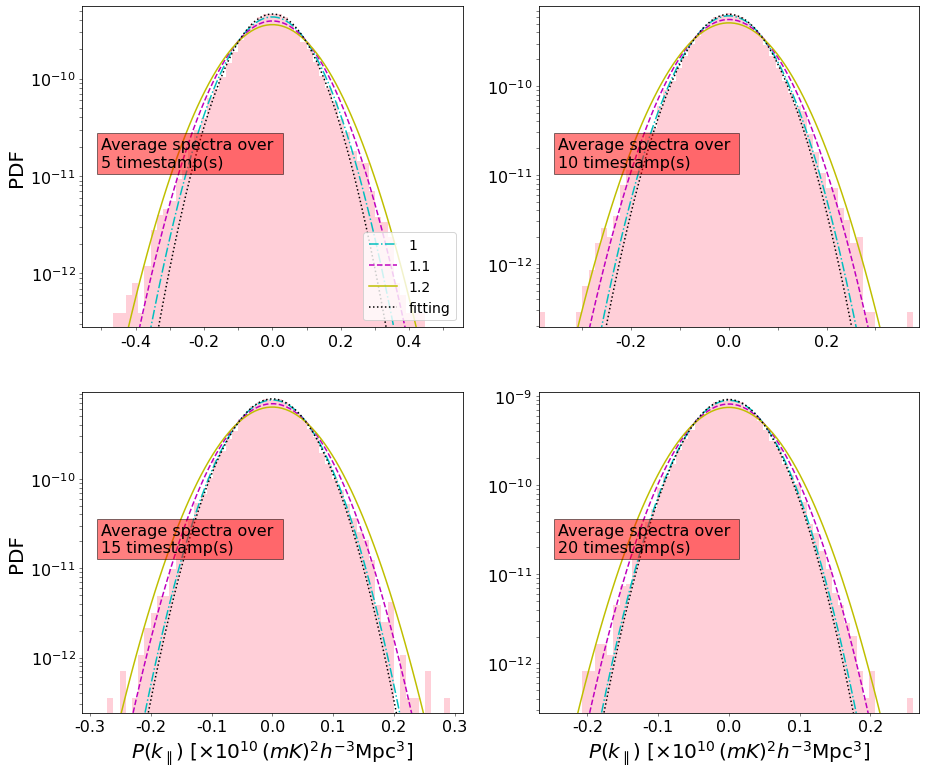

In [62]:
# A larger window (2000), with different Gaussian sigma, substract the mean
uvp_plot = uvp_cross
num_time_samples_list = [5,10,15,20]
fig, axes = plt.subplots(figsize=(15,13), ncols=2, nrows=2)

for ax_idx, num_time_samples in enumerate(num_time_samples_list):
    col_idx = ax_idx%2
    row_idx = int((ax_idx - col_idx)/2)
    times = np.arange(num_time_samples)
   
    # Get all keys
    keys = uvp_plot.get_all_keys()
    blpt_weights = np.array([[1. for item in times] for key in keys])
    dlys = uvp_plot.get_dlys(0) * 1e9
    delay_args = np.append(np.argwhere(dlys< -2000), np.argwhere(dlys> 2000))
    ps_real_time_avg = []
    for dly in delay_args:
        ps = np.array([[uvp_plot.get_data(key)[time, dly] for time in times] for key in keys])
        ps_real_time_avg.extend((np.sum(ps.real*blpt_weights, axis=1)/np.sum(blpt_weights, axis=1).clip(1e-10, np.inf)).flatten())
    ps_real_time_avg = np.array(ps_real_time_avg) - np.mean(ps_real_time_avg)
    # The ratio of error bars to the original one
    psunits = uvp_plot.units
    if "h^-1" in psunits: psunits = psunits.replace("h^-1", "h^{-1}")
    if "h^-3" in psunits: psunits = psunits.replace("h^-3", "h^{-3}")
    if "Mpc" in psunits and "\\rm" not in psunits: 
        psunits = psunits.replace("Mpc", r"{\rm Mpc}")
    if "pi" in psunits and "\\pi" not in psunits: 
        psunits = psunits.replace("pi", r"\pi")
    
    ax = axes[row_idx, col_idx]
    Lap_sigma_list = np.zeros(num_time_samples)
    for time in times:
        Lap_sigma_list[time] = np.sqrt(np.mean(np.square([uvp_plot.get_stats("autos_diag", key)[time].real for key in keys])))
    Gauss_sigma = np.sqrt(np.sum(Lap_sigma_list**2))/num_time_samples
    vlim = 6*Gauss_sigma
    n_in_bins, bins_edge, _ = ax.hist(ps_real_time_avg, log=True, density=True, bins=61, range=(-vlim, vlim), alpha=0.75,
                           color='pink')
    ax.set_xlim(-vlim, vlim)
    ax.set_ylim(0,1.2*n_in_bins.max())
    px = np.linspace(-vlim, vlim, 100)
    custom_cycler = (cycler.cycler(color=['c', 'm', 'y', 'k']) +
                 cycler.cycler(ls=["-.", "--", "-", ":"]))
    ax.set_prop_cycle(custom_cycler)
    for factor in [1,1.1,1.2]:
    # Calculate the equivalent Gaussian pdf
        Gauss_curve = np.exp(-px**2/2/(factor*Gauss_sigma)**2)/np.sqrt(2*np.pi*(factor*Gauss_sigma)**2)
        ax.plot(px, Gauss_curve, label=str(factor))
    
    bins_center = (bins_edge[1:] + bins_edge[:-1])/2
    best_vals, covar = curve_fit(gaussian, bins_center, n_in_bins, p0=init_vals)
    ax.plot(px, gaussian(px, *best_vals), label='fitting')
    
    ax.tick_params(which='both', labelsize=16, length=3, width=0.5)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1e9))
    xticks = ax.get_xticks()
    ax.set_xticklabels(xticks/1e10)
    if row_idx == 1:
        ax.set_xlabel("$P(k_\parallel)$ $[\\times 10^{10}\,%s]$" % psunits, fontsize=20)
    if col_idx == 0: 
        ax.set_ylabel("PDF", fontsize=20)
    if ax_idx == 0:
        ax.legend(loc='lower right', fontsize=14)
    ax.text(0.05, 0.5, "Average spectra over \n{} timestamp(s)".format(num_time_samples), transform=ax.transAxes, bbox=dict(facecolor='red', alpha=0.5), fontsize=16, color='k')

#### on medium baseline group